In [4]:
token_file_path = '../caselaw_scrape/court_listener_token.txt'  # Adjust the path if the file is in a different directory

# Reading the API token from the file
with open(token_file_path, 'r') as file:
    api_token = file.read().strip()#

In [5]:
import pandas as pd

df = pd.read_json('../caselaw_scrape/dataset_complete_08222024.jsonl', lines=True)

In [7]:
unique_docket_nums = df["docket_num"].unique().tolist()
print("Number of docket numbers:", len(unique_docket_nums))

Number of docket numbers: 354


In [67]:
test_num = unique_docket_nums[1]
print(test_num)

20-828


For each docket number, make a request on supremecourt.gov and grab the case name. Then search courtlistener for that case name and store the case ID. Finally perform cited by lookup based on the ID

In [54]:
import pandas as pd

new_df = pd.DataFrame({
    "docket_num": unique_docket_nums,
    "cl_id": None,  
    "title": None,  
    "docketed_date": None, 
    "lower_ct": None, 
    "lower_ct_num": None, 
    "question_presented": None,
    "times_cited": None,
})


In [24]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.firefox.service import Service
from webdriver_manager.firefox import GeckoDriverManager
import pandas as pd
import time
import random

def extract_docket_info(docket_number):
    """ Extracts case details from the Supreme Court website for a given docket number. """

    options = Options()
    options.add_argument("--headless")  # Run in headless mode
    service = Service(GeckoDriverManager().install())
    
    # Start a new WebDriver session for each request
    driver = webdriver.Firefox(service=service, options=options)

    url = f"https://www.supremecourt.gov/docket/docketfiles/html/public/{docket_number}.html"
    case_data = {
        "docket_num": docket_number,
        "title": None,
        "docketed_date": None,
        "lower_ct": None,
        "lower_ct_num": None,
        "question_presented_link": None
    }
    
    try:
        driver.get(url)

        # Locate the docketinfo table
        docket_info_table = driver.find_element(By.ID, "docketinfo")
        rows = docket_info_table.find_elements(By.TAG_NAME, "tr")

        for row in rows:
            cells = row.find_elements(By.TAG_NAME, "td")
            if len(cells) >= 2:  # Ensure the row has at least 2 cells
                label = cells[0].text.strip()
                value = cells[1].text.strip()

                if "Title:" in label:
                    case_data["title"] = value
                elif "Docketed:" in label:
                    case_data["docketed_date"] = value
                elif "Lower Ct:" in label:
                    case_data["lower_ct"] = value
                elif "Case Numbers:" in label:
                    case_data["lower_ct_num"] = value

        # Find "Question Presented" link
        question_links = docket_info_table.find_elements(By.XPATH, "//a[contains(text(), 'Questions Presented')]")
        if question_links:
            case_data["question_presented_link"] = question_links[0].get_attribute("href")
    
    except Exception as e:
        print(f"Error extracting data for docket {docket_number}: {str(e)}")
    
    finally:
        driver.quit()  # Ensure the driver is closed after each request
    
    return case_data

In [25]:
# Test with a docket number
test_data = extract_docket_info(test_num)

driver.quit()

In [26]:
print(test_data)

{'docket_num': '20-828', 'title': 'Federal Bureau of Investigation, et al., Petitioners\nv.\nYassir Fazaga, et al.', 'docketed_date': 'December 18, 2020', 'lower_ct': 'United States Court of Appeals for the Ninth Circuit', 'lower_ct_num': '(12-56867, 12-56874, 13-55017)', 'question_presented_link': 'https://www.supremecourt.gov/docket/docketfiles/html/qp/20-00828qp.pdf'}


In [42]:
from tqdm import tqdm

cases_list = []
for docket in tqdm(unique_docket_nums):
    case_data = extract_docket_info(docket)
    cases_list.append(case_data)
    
    # Random sleep to avoid being blocked
    sleep_time = random.uniform(1, 2)
    # print(f"Sleeping for {sleep_time:.2f} seconds...")
    time.sleep(sleep_time)

# Convert to DataFrame
df_meta = pd.DataFrame(cases_list)

 22%|██▏       | 77/354 [19:57<1:11:49, 15.56s/it]


ValueError: response body:
{"message":"API rate limit exceeded for 47.230.208.158. (But here's the good news: Authenticated requests get a higher rate limit. Check out the documentation for more details.)","documentation_url":"https://docs.github.com/rest/overview/resources-in-the-rest-api#rate-limiting"}

request url:
https://api.github.com/repos/mozilla/geckodriver/releases/latest
response headers:
{'Date': 'Mon, 10 Mar 2025 00:08:53 GMT', 'Server': 'Varnish', 'Strict-Transport-Security': 'max-age=31536000; includeSubdomains; preload', 'X-Content-Type-Options': 'nosniff', 'X-Frame-Options': 'deny', 'X-XSS-Protection': '1; mode=block', 'Content-Security-Policy': "default-src 'none'; style-src 'unsafe-inline'", 'Access-Control-Allow-Origin': '*', 'Access-Control-Expose-Headers': 'ETag, Link, Location, Retry-After, X-GitHub-OTP, X-RateLimit-Limit, X-RateLimit-Remaining, X-RateLimit-Reset, X-RateLimit-Used, X-RateLimit-Resource, X-OAuth-Scopes, X-Accepted-OAuth-Scopes, X-Poll-Interval, X-GitHub-Media-Type, Deprecation, Sunset', 'Content-Type': 'application/json; charset=utf-8', 'Referrer-Policy': 'origin-when-cross-origin, strict-origin-when-cross-origin', 'X-GitHub-Media-Type': 'github.v3; format=json', 'X-RateLimit-Limit': '60', 'X-RateLimit-Remaining': '0', 'X-RateLimit-Reset': '1741567739', 'X-RateLimit-Resource': 'core', 'X-RateLimit-Used': '60', 'Content-Length': '280', 'X-GitHub-Request-Id': '5DCB:340C96:1DB5176:3C14630:67CE2D95'}


In [ ]:
print(df_meta.head())

In [50]:
import requests
from bs4 import BeautifulSoup
import json

test_name = test_data["title"].replace("\n", "")
search_endpoint = f"https://www.courtlistener.com/api/rest/v4/search/?q={test_name}"
docket_endpoint = f"https://www.courtlistener.com/api/rest/v4/dockets/?docket_number={test_num}&court=scotus"

headers = {
    'Authorization': f'Token {api_token}',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36'
}

url = docket_endpoint
test_response = requests.get(url, headers=headers)

In [52]:
print(test_num)
print(test_response)

20-5279
<Response [200]>


In [53]:
main_data = test_response.json()
print(json.dumps(main_data, indent=4))

{
    "count": "https://www.courtlistener.com/api/rest/v4/dockets/?count=on&court=scotus&docket_number=20-5279",
    "next": null,
    "previous": null,
    "results": [
        {
            "resource_uri": "https://www.courtlistener.com/api/rest/v4/dockets/63141398/",
            "id": 63141398,
            "court": "https://www.courtlistener.com/api/rest/v4/courts/scotus/",
            "court_id": "scotus",
            "original_court_info": null,
            "idb_data": null,
            "clusters": [
                "https://www.courtlistener.com/api/rest/v4/clusters/6448935/"
            ],
            "audio_files": [],
            "assigned_to": null,
            "referred_to": null,
            "absolute_url": "/docket/63141398/wooden-v-united-states/",
            "date_created": "2022-03-08T07:00:52.025655-08:00",
            "date_modified": "2022-03-08T07:00:52.852569-08:00",
            "source": 2,
            "appeal_from_str": "",
            "assigned_to_str": "",
   

In [86]:
import requests
from bs4 import BeautifulSoup
import json

def download_cl_id(docket_num):
    docket_endpoint = f"https://www.courtlistener.com/api/rest/v4/dockets/?docket_number={docket_num}&court=scotus"
    
    headers = {
        'Authorization': f'Token {api_token}',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36'
    }
    
    url = docket_endpoint
    try:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            data = response.json()
        
            return data["results"][0]["id"]
        else:
            return None
    except Exception as e:
        print(f"Error downloading courtlistner id for {docket_num}: {str(e)}")

    return None

In [87]:
test_cl_id = download_cl_id(test_num)
print(test_cl_id)
print(type(test_cl_id))

63134644
<class 'int'>


In [89]:
def get_num_cited(cl_id):
    cited_endpoint = f"https://www.courtlistener.com/api/rest/v4/opinions-cited/?cited_opinion={cl_id}&count=on"

    headers = {
        'Authorization': f'Token {api_token}',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36'
    }

    url = cited_endpoint
    try:
        response = requests.get(url, headers=headers)
        # print(response)
        if response.status_code == 200:
            
            data = response.json()
            # print(json.dumps(data, indent=4))
            return data["count"]
        else:
            return 0
    except Exception as e:
        print(f"Error downloading number of citations for {cl_id}: {str(e)}")

    return 0

In [90]:
print(get_num_cited(test_cl_id)) # 2812209 is the id for Obergafel

0


In [91]:
tqdm.pandas()

# Function to modify each row
def process_row(row):
    docket_num = row["docket_num"]
    cl_id = download_cl_id(docket_num)
    row["cl_id"] = cl_id
    row["time_cited"] = get_num_cited(cl_id)
    return row

# Apply the function with a progress bar
new_df = new_df.progress_apply(process_row, axis=1)

 24%|██▍       | 86/354 [03:32<10:44,  2.41s/it]

Error downloading courtlistner id for None: list index out of range


 32%|███▏      | 112/354 [04:17<07:34,  1.88s/it]

Error downloading courtlistner id for 20-499: list index out of range


 52%|█████▏    | 183/354 [07:29<05:28,  1.92s/it]

Error downloading courtlistner id for 18-921: list index out of range


 62%|██████▏   | 219/354 [08:42<04:06,  1.82s/it]

Error downloading courtlistner id for 17-467: list index out of range


 74%|███████▍  | 262/354 [09:50<02:22,  1.55s/it]

Error downloading courtlistner id for 18-8332: list index out of range


 74%|███████▍  | 263/354 [09:51<02:23,  1.58s/it]

Error downloading courtlistner id for 18-761: list index out of range


 80%|███████▉  | 282/354 [10:25<02:11,  1.82s/it]

Error downloading courtlistner id for 18-364: list index out of range


 83%|████████▎ | 294/354 [10:51<03:01,  3.02s/it]

Error downloading courtlistner id for 18-12: list index out of range


 88%|████████▊ | 312/354 [11:24<01:09,  1.64s/it]

Error downloading courtlistner id for 17-1676: list index out of range


 88%|████████▊ | 313/354 [11:26<01:06,  1.62s/it]

Error downloading courtlistner id for 18-5181: list index out of range


 89%|████████▉ | 315/354 [11:29<01:02,  1.60s/it]

Error downloading courtlistner id for 17-7894: list index out of range


 90%|████████▉ | 317/354 [11:32<00:58,  1.57s/it]

Error downloading courtlistner id for 17-1284: list index out of range


 91%|█████████ | 321/354 [11:39<00:57,  1.73s/it]

Error downloading courtlistner id for 17-1364: list index out of range


 98%|█████████▊| 347/354 [12:44<00:43,  6.24s/it]

Error downloading courtlistner id for 17-654: list index out of range


100%|██████████| 354/354 [12:56<00:00,  2.19s/it]


C:\Users\jwwoo\AppData\Local\Temp\ipykernel_12372\163536240.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = new_df["times_cited"].fillna(0)


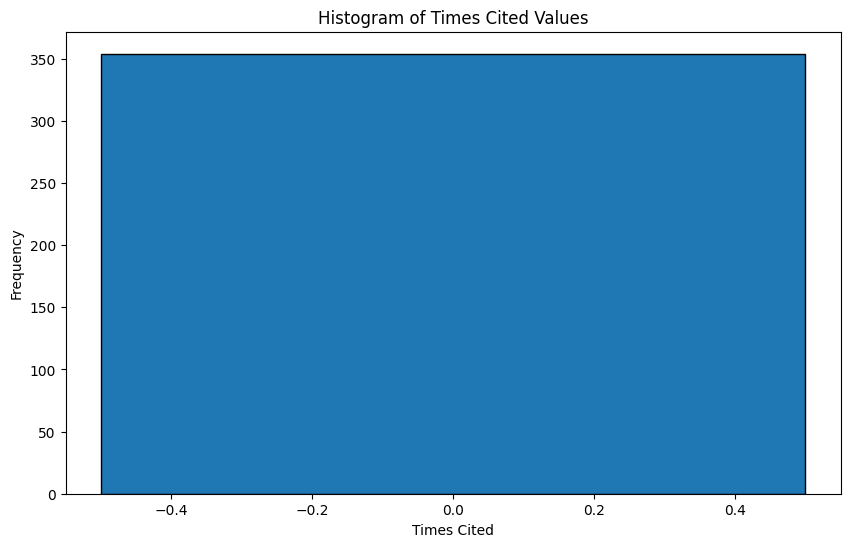

In [99]:
import matplotlib.pyplot as plt

data = new_df["times_cited"].fillna(0)

plt.figure(figsize=(10, 6))
plt.hist(data, bins=range(0, int(data.max()) + 2), edgecolor="black", align="left")

# Labels and title
plt.xlabel("Times Cited")
plt.ylabel("Frequency")
plt.title("Histogram of Times Cited Values")

plt.show()

In [100]:
print(data.max())

0
